When you read that “Maurita and Jade both were at the scene of the car crash,” you can infer that “Multiple people saw the accident.”  This is an example of textual entailment.  Textual entailment is an exercise in first-order logic, which uses rules for inference to help inform decisions.  A computer program that takes on the task of textual entailment attempts to categorize an order pair of sentences into one of three categories.  The first category, called positive entailment, occurs when you can use the first sentence to prove that a second sentence is true.  The second category, negative entailment, is the inverse of positive entailment.  This occurs when the first sentence can be used to disprove the second sentence.  Finally, if the two sentences have no correlation, they are considered to have a neutral entailment.  This article will guide you through building a neural network to learn this task in Tensorflow.

Before we get started, make sure you have Numpy and Matplotlib installed, as well as Tensorflow.  To get a better sense of progress during network training, you're also welcome to install TQDM, but it's not required.  We'll go ahead and do all the necessary imports right now, as well as letting Jupyter Notebook know that it should display graphs and images in the notebook itself.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

The files we're about to download are going to take a while, so if you're following along by running the program feel free to hop down and start the next few cells running while you read this.

In our example sentence pair, we can prove the second sentence from the first sentence (positive entailment).  Given that Maurita and Jade were both there to view the crash, multiple people must have seen it.  “Car crash” and “accident” have similar meanings, but they aren’t the same word.  In fact, entailment doesn’t always mean that the sentences share words, as can be seen in this sentence pair, which only shares the word “the”.

Let’s consider another sentence pair.  How, if at all, does the sentence “Two dogs played in the park with the old man” entail “There was only one canine in the park that day?”  If there are two dogs there must be at least two canines.  Since the second sentence contradicts that idea, this is negative entailment.

Finally, to illustrate neutral entailment, we consider how, if at all, the sentence “I played baseball with the kids” entails “The kids love ice cream”?   Playing baseball and loving ice cream have absolutely nothing to do with each other.  I could play baseball with ice cream lovers, and I could play baseball with ice cream haters, both equally possible.  Thus, the first sentence says nothing about the truth or falsehood of the second.

Unfortunately for neural networks, they primarily work with numeric values.  To get around this, we need to represent our words as numbers in some way.  Ideally, these numbers mean something; we could use the character codes of the letters in the word, but that doesn’t tell us anything about the meaning of it, making Tensorflow have to do a lot of work to tell that “dog” and “canine” are close to the same concept.  Turning similar knowledge into something a neural network can understand happens by a process called word vectorization.

One way common way to create word vectorizations is to have each word represent a single point in a very high-dimensional space.  Words with similar representations should be relatively close together in this space.  For example, each of the colors have representations that are usually very similar to each other.  Demonstrations of this can be found in Tensorflow’s own tutorial on word vectorization [here](https://www.tensorflow.org/tutorials/word2vec). 

Fortunately for us, we won’t need to create a new representation of words as numbers.  There already exist quite a few fantastic general-purpose vector representations of words, as well as ways to train even more specialized material if the general-purpose data isn’t enough.  The associated notebook for this tutorial was designed to work with Stanford’s GloVe word vectorization, the pre-trained data for which can be found at http://nlp.stanford.edu/projects/glove/.   We’ll be using the 6-billion-token Wikipedia 2014 + Gigaword 5 vectors, since it’s the smallest and thus the easiest to download.  We’ll do that programmatically, but keep in mind that it may take a while to run; it’s a fairly large file.

At the same time, we'll also be picking up our dataset for textual entailment, Stanford's SNLI dataset.  We'll be using the development set, which only has 10,000 sentence pairs, in the interest of speed, but if you're interested in getting better results and have time to spare for training you can try using the full dataset instead.

In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [3]:
if sys.version[0] == "3": from urllib.request import urlretrieve
else: from urllib import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://www-nlp.stanford.edu/data/glove.6B.zip", glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("http://www-nlp.stanford.edu/projects/snli/snli_1.0.zip", snli_zip_file)


In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

Now that we have our glove vectors downloaded, we can load them into memory, deserializing the space separated format into a Python dictionary: 

In [5]:
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

Once we have our words, we need our input to contain entire sentences and process it through a neural network.  Let's start with making the sequence:

In [6]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

To better visualize the word vectorization process and see what the computer sees when it looks at a sentence, we can represent the vectors as images.  Feel free to play around with visualizing your own sentences.

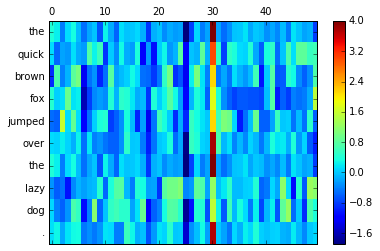

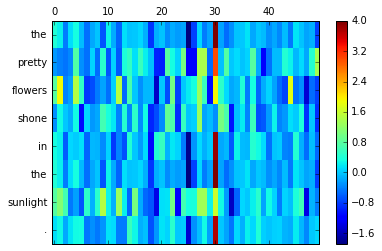

In [7]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

Unlike images, sentences are inherently sequential and can’t be constrained by size, and so instead of fully connected forward-feeding networks that take in one input value and simply run until it produces a single output, we need a new type of network.  We need… *recurrence*.

Recurrent Neural Networks (also known as RNNs) are a sequence-learning tool for neural networks.  This type of neural network has only one layer’s worth of hidden inputs, which is re-used for each input from the sequence along with a “memory” that’s passed ahead to the next input’s calculations.  These are calculated using matrix multiplication where the matrix indices are trained weights just like they are in a fully connected layer.  The same calculations are repeated for each input in the sequence, meaning that a single “layer” of a recurrent neural network can be unrolled into many layers.  In fact, there will be as many layers as there are inputs in the sequence.  This allows the network to process a very complex sentence.  Tensorflow includes its own implementation of a vanilla RNN, which can be added to your Tensorflow graph as follows:

In [8]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

In theory, the network would be able to remember things from one of the first layers, much earlier in the sentence, even when at the end of the sentence.  The main problem with this form of recurrence is that, in practice, earlier data is completely drowned out by newer inputs and information that doesn’t end up being nearly as important.  Recurrent neural networks, or at least a neural network with standard hidden units, often fail to hold on to information for long periods of time.  This failure is known as the *vanishing gradient problem*.

The simplest way to visualize this is by example.  In the simplest case, input and “memory” are roughly equally weighted.  The first input into the data will affect approximately half of the first output (the other half being the starting “memory”), then a quarter of the second output, then an eighth of the third output, and so on.

This means we can’t use vanilla recurrent networks, at least not if we want to keep track of both sentences in this pair.  The solution is to use a different type of recurrent network layer.  Perhaps the simplest of these is the Long Short-Term Memory layer, also known as an LSTM.  In an LSTM, instead of the input always being used the same way every time in the calculation of current memory, the network makes a decision on how much the current values can affect the memory by an “input gate”, and makes another decision on what memory is forgotten by an appropriately-named “forget gate”, and finally makes a third decision on what parts of memory are sent to the next timestep by an “output gate”.  

The combination of these three creates a choice: a single LSTM node can either keep information in long-term memory or keep it in short-term memory, but it can’t do both at the same time.  Short-term memory LSTMs usually train to have relatively open input gates that let a lot of information in, and forget many things often, while long-term memory LSTMs have input gates that only allow very small, very specific pieces of information in.  This tightness means that it doesn’t lose its information easily, allowing for longer retention time.

In general, LSTMs are very cryptic. Different LSTM nodes in the same network may have vastly different gates which rely upon one another, such as perhaps having a short-term gate remember the word “not” in a sentence “John did not go to the store,” so that when the word “go” appears, a long-term gate could remember “not go” instead of “go”.  Of course, this is a contrived example, and in practice these relationships are very complex to the point of being indecipherable.  

Since we aren’t going to use a vanilla RNN layer in our network, let's clear out the graph and add an LSTM layer, which Tensorflow also includes by default.  Since this is going to be the first part of our actual network, let's also define all the constants we'll need for the actual network, which we'll talk about as they come up in the actual network:

In [9]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res

def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e


We'll also reset the graph to not include the RNN cell we added earlier, since we won't be using that for this network:

In [10]:
tf.reset_default_graph()

With both those out of the way, we can define our LSTM using Tensorflow as follows:

In [11]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

If we simply used LSTM layers and nothing more, the network might read a lot of meaning into common, but inconsequential, words like ‘a’, ‘the’, and ‘and’.  The network might incorrectly believe that it has found negative entailment if one sentence uses the phrase “an animal” and the other uses “the animal”, even if those phrases refer to the same object.  To solve this, we need to regulate to see if individual words end up being important to the meaning as a whole and we do that by a process called dropout.
Dropout is a regularization pattern in neural network design that revolves around dropping randomly selected hidden and visible unit.  As the size of a neural network increases, so does the amount of parameters used to calculate the final result, each of which contributes to overfitting if trained all at once.  In order to regularize for this, a portion of the units contained within the network are selected randomly and zeroed out temporarily during training, and their outputs are scaled appropriately during actual use. 

Dropout on “standard” (i.e. fully connected) layers is also useful because it effectively trains multiple smaller networks, and then combines them during testing time.  One of the constants in machine learning is that combining multiple models nearly always makes for a better method than a single model on its own, and dropout serves to turn a single neural network into multiple smaller neural networks that share some nodes and thus some parameters with the others.

A dropout layer has one hyperparameter known as p, which is simply the probability that each unit is kept in the network for that iteration of training.   The units that are kept provide their outputs to the next layer, and the units that are not kept provide nothing.

Unfortunately, dropout does not play particularly nicely with LSTM layers' internal gates.  The loss of certain pieces of crucial memory means that complicated relationships required for first order logic have a harder time forming with dropout, and so for our LSTM layer we’ll skip using dropout on internal gates, instead using it on everything else.  Thankfully, this is the default implementation of Tensorflow’s DropoutWrapper for recurrent layers.

In [12]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

With all the explanations out of the way, we can finish up our model.  The first step is tokenizing and using our GloVe dictionary to turn the two input sentences into a single sequence of vectors. Since we can’t effectively use dropout on information that gets passed within an LSTM, we’ll use dropout on features from words and on final output instead, effectively using dropout on the first and last layers from the unrolled LSTM network portions.  The final output from the LSTMs will be passed into a set of fully connected layers, and then from that we’ll get a single real-valued score that indicates how strong each of the kinds of entailment are, which we use to select our final result and our confidence in that result.

In [13]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.

hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')

# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.

lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.

lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.

# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.

fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In order to test the accuracy and begin to optimize constraints, we need to   define what the accuracy is.  This is the percentage of correctly predicted labels. 

We also need to determine a loss, to show how poorly the network is doing. Since we have both classification scores and optimal scores, the choice here is using a variation on softmax loss from Tensorflow: `tf.nn.softmax_cross_entropy_with_logits`. We add in regularization losses to help with overfitting, and then prepare an optimizer to learn how to reduce the loss.

In [14]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

Finally, we can train the network!  If you installed TQDM, you can use it to keep track of progress as the network trains.

In [15]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  1%|          | 9/782 [00:01<02:42,  4.76it/s]

Iter 0, Minibatch Loss= 1.113067, Training Accuracy= 0.28906
Iter 10, Minibatch Loss= 1.096956, Training Accuracy= 0.36719

  3%|▎         | 20/782 [00:04<02:43,  4.67it/s]


Iter 20, Minibatch Loss= 1.096971, Training Accuracy= 0.37500

  4%|▍         | 30/782 [00:06<02:14,  5.61it/s]


Iter 30, Minibatch Loss= 1.092645, Training Accuracy= 0.38281

  5%|▌         | 40/782 [00:07<01:43,  7.19it/s]


Iter 40, Minibatch Loss= 1.089020, Training Accuracy= 0.45312

  6%|▋         | 50/782 [00:08<01:56,  6.28it/s]


Iter 50, Minibatch Loss= 1.089523, Training Accuracy= 0.39844

  8%|▊         | 59/782 [00:10<01:38,  7.32it/s]


Iter 60, Minibatch Loss= 1.096653, Training Accuracy= 0.32812

  9%|▉         | 70/782 [00:11<01:09, 10.20it/s]


Iter 70, Minibatch Loss= 1.087425, Training Accuracy= 0.42188

 10%|█         | 80/782 [00:12<01:07, 10.43it/s]


Iter 80, Minibatch Loss= 1.074639, Training Accuracy= 0.42188

 11%|█▏        | 89/782 [00:13<01:07, 10.21it/s]


Iter 90, Minibatch Loss= 1.097314, Training Accuracy= 0.41406

 13%|█▎        | 100/782 [00:14<01:16,  8.91it/s]


Iter 100, Minibatch Loss= 1.081051, Training Accuracy= 0.45312

 14%|█▍        | 110/782 [00:16<01:51,  6.01it/s]


Iter 110, Minibatch Loss= 1.088137, Training Accuracy= 0.44531

 15%|█▌        | 119/782 [00:17<01:18,  8.47it/s]


Iter 120, Minibatch Loss= 1.089923, Training Accuracy= 0.42188

 16%|█▋        | 129/782 [00:18<01:30,  7.18it/s]


Iter 130, Minibatch Loss= 1.070641, Training Accuracy= 0.42188

 18%|█▊        | 140/782 [00:20<01:27,  7.31it/s]


Iter 140, Minibatch Loss= 1.104768, Training Accuracy= 0.37500

 19%|█▉        | 150/782 [00:21<01:21,  7.76it/s]


Iter 150, Minibatch Loss= 1.087787, Training Accuracy= 0.39844

 20%|██        | 160/782 [00:23<02:14,  4.62it/s]


Iter 160, Minibatch Loss= 1.092689, Training Accuracy= 0.38281

 22%|██▏       | 169/782 [00:24<01:18,  7.77it/s]


Iter 170, Minibatch Loss= 1.095503, Training Accuracy= 0.33594

 23%|██▎       | 179/782 [00:25<00:59, 10.10it/s]


Iter 180, Minibatch Loss= 1.089509, Training Accuracy= 0.39844

 24%|██▍       | 190/782 [00:26<01:04,  9.17it/s]


Iter 190, Minibatch Loss= 1.085175, Training Accuracy= 0.36719

 26%|██▌       | 200/782 [00:28<01:19,  7.34it/s]


Iter 200, Minibatch Loss= 1.099107, Training Accuracy= 0.34375

 27%|██▋       | 210/782 [00:29<01:00,  9.44it/s]


Iter 210, Minibatch Loss= 1.098441, Training Accuracy= 0.36719

 28%|██▊       | 219/782 [00:30<01:06,  8.41it/s]


Iter 220, Minibatch Loss= 1.091500, Training Accuracy= 0.39062

 29%|██▉       | 229/782 [00:31<00:50, 10.89it/s]


Iter 230, Minibatch Loss= 1.081346, Training Accuracy= 0.41406

 31%|███       | 239/782 [00:32<00:46, 11.57it/s]


Iter 240, Minibatch Loss= 1.066600, Training Accuracy= 0.42969

 32%|███▏      | 249/782 [00:33<00:44, 12.00it/s]


Iter 250, Minibatch Loss= 1.077369, Training Accuracy= 0.42188

 33%|███▎      | 260/782 [00:34<01:16,  6.78it/s]


Iter 260, Minibatch Loss= 1.085431, Training Accuracy= 0.42188

 35%|███▍      | 270/782 [00:36<01:08,  7.47it/s]


Iter 270, Minibatch Loss= 1.035360, Training Accuracy= 0.47656

 36%|███▌      | 280/782 [00:37<00:57,  8.79it/s]


Iter 280, Minibatch Loss= 1.052166, Training Accuracy= 0.45312

 37%|███▋      | 289/782 [00:38<00:46, 10.70it/s]


Iter 290, Minibatch Loss= 1.083192, Training Accuracy= 0.46094

 38%|███▊      | 300/782 [00:39<00:43, 11.07it/s]


Iter 300, Minibatch Loss= 1.094346, Training Accuracy= 0.41406

 40%|███▉      | 310/782 [00:40<00:43, 10.86it/s]


Iter 310, Minibatch Loss= 1.036944, Training Accuracy= 0.46094

 41%|████      | 320/782 [00:41<00:41, 11.11it/s]


Iter 320, Minibatch Loss= 1.049542, Training Accuracy= 0.45312

 42%|████▏     | 330/782 [00:42<00:39, 11.38it/s]


Iter 330, Minibatch Loss= 1.092343, Training Accuracy= 0.36719

 43%|████▎     | 340/782 [00:43<00:38, 11.45it/s]


Iter 340, Minibatch Loss= 1.086655, Training Accuracy= 0.37500

 45%|████▍     | 350/782 [00:44<00:41, 10.34it/s]


Iter 350, Minibatch Loss= 1.083910, Training Accuracy= 0.40625

 46%|████▌     | 359/782 [00:45<00:39, 10.60it/s]


Iter 360, Minibatch Loss= 1.040063, Training Accuracy= 0.49219

 47%|████▋     | 370/782 [00:46<00:38, 10.77it/s]


Iter 370, Minibatch Loss= 1.066182, Training Accuracy= 0.46875

 49%|████▊     | 380/782 [00:47<00:36, 11.16it/s]


Iter 380, Minibatch Loss= 1.018333, Training Accuracy= 0.49219

 50%|████▉     | 390/782 [00:48<00:56,  6.97it/s]


Iter 390, Minibatch Loss= 1.039768, Training Accuracy= 0.48438

 51%|█████     | 399/782 [00:50<00:54,  6.97it/s]


Iter 400, Minibatch Loss= 1.091033, Training Accuracy= 0.36719

 52%|█████▏    | 409/782 [00:51<00:38,  9.76it/s]


Iter 410, Minibatch Loss= 1.079426, Training Accuracy= 0.48438

 54%|█████▎    | 420/782 [00:52<00:33, 10.85it/s]


Iter 420, Minibatch Loss= 1.040623, Training Accuracy= 0.45312

 55%|█████▍    | 430/782 [00:53<00:45,  7.78it/s]


Iter 430, Minibatch Loss= 1.090769, Training Accuracy= 0.37500

 56%|█████▌    | 439/782 [00:55<01:00,  5.71it/s]


Iter 440, Minibatch Loss= 1.059326, Training Accuracy= 0.48438

 58%|█████▊    | 450/782 [00:56<00:45,  7.26it/s]


Iter 450, Minibatch Loss= 1.048350, Training Accuracy= 0.49219

 59%|█████▉    | 460/782 [00:58<00:49,  6.57it/s]


Iter 460, Minibatch Loss= 1.067126, Training Accuracy= 0.49219

 60%|█████▉    | 469/782 [00:59<00:39,  8.00it/s]


Iter 470, Minibatch Loss= 1.014902, Training Accuracy= 0.51562

 61%|██████▏   | 480/782 [01:01<00:39,  7.59it/s]


Iter 480, Minibatch Loss= 1.043228, Training Accuracy= 0.46875

 63%|██████▎   | 490/782 [01:02<00:35,  8.28it/s]


Iter 490, Minibatch Loss= 1.018691, Training Accuracy= 0.50000

 64%|██████▍   | 500/782 [01:03<00:38,  7.37it/s]


Iter 500, Minibatch Loss= 1.034777, Training Accuracy= 0.49219

 65%|██████▌   | 510/782 [01:05<00:44,  6.06it/s]


Iter 510, Minibatch Loss= 1.052097, Training Accuracy= 0.48438

 66%|██████▋   | 519/782 [01:06<00:36,  7.23it/s]


Iter 520, Minibatch Loss= 1.058522, Training Accuracy= 0.46875

 68%|██████▊   | 530/782 [01:08<00:46,  5.47it/s]


Iter 530, Minibatch Loss= 1.088882, Training Accuracy= 0.35156

 69%|██████▉   | 540/782 [01:10<00:40,  5.92it/s]


Iter 540, Minibatch Loss= 1.084252, Training Accuracy= 0.39062

 70%|███████   | 550/782 [01:11<00:37,  6.27it/s]


Iter 550, Minibatch Loss= 0.985752, Training Accuracy= 0.51562

 72%|███████▏  | 560/782 [01:12<00:24,  9.18it/s]


Iter 560, Minibatch Loss= 1.035077, Training Accuracy= 0.46094

 73%|███████▎  | 569/782 [01:13<00:19, 10.71it/s]


Iter 570, Minibatch Loss= 1.055261, Training Accuracy= 0.47656

 74%|███████▍  | 579/782 [01:14<00:18, 11.27it/s]


Iter 580, Minibatch Loss= 1.063931, Training Accuracy= 0.45312

 75%|███████▌  | 590/782 [01:15<00:20,  9.48it/s]


Iter 590, Minibatch Loss= 1.004723, Training Accuracy= 0.50781

 77%|███████▋  | 600/782 [01:16<00:18, 10.02it/s]


Iter 600, Minibatch Loss= 1.119748, Training Accuracy= 0.38281

 78%|███████▊  | 610/782 [01:18<00:20,  8.20it/s]


Iter 610, Minibatch Loss= 1.055980, Training Accuracy= 0.45312

 79%|███████▉  | 620/782 [01:19<00:20,  7.85it/s]


Iter 620, Minibatch Loss= 1.056684, Training Accuracy= 0.43750

 81%|████████  | 630/782 [01:20<00:15,  9.56it/s]


Iter 630, Minibatch Loss= 1.026813, Training Accuracy= 0.50781

 82%|████████▏ | 639/782 [01:21<00:14,  9.90it/s]


Iter 640, Minibatch Loss= 1.041280, Training Accuracy= 0.48438

 83%|████████▎ | 649/782 [01:23<00:17,  7.52it/s]


Iter 650, Minibatch Loss= 1.026468, Training Accuracy= 0.49219

 84%|████████▍ | 660/782 [01:24<00:15,  7.73it/s]


Iter 660, Minibatch Loss= 1.034440, Training Accuracy= 0.47656

 86%|████████▌ | 670/782 [01:26<00:17,  6.28it/s]


Iter 670, Minibatch Loss= 1.055578, Training Accuracy= 0.46094

 87%|████████▋ | 680/782 [01:27<00:12,  8.09it/s]


Iter 680, Minibatch Loss= 0.990272, Training Accuracy= 0.60938

 88%|████████▊ | 690/782 [01:28<00:09, 10.04it/s]


Iter 690, Minibatch Loss= 1.075667, Training Accuracy= 0.44531

 89%|████████▉ | 699/782 [01:29<00:07, 10.51it/s]


Iter 700, Minibatch Loss= 1.037086, Training Accuracy= 0.50000

 91%|█████████ | 709/782 [01:30<00:07, 10.27it/s]


Iter 710, Minibatch Loss= 1.001872, Training Accuracy= 0.52344

 92%|█████████▏| 720/782 [01:32<00:09,  6.87it/s]


Iter 720, Minibatch Loss= 1.005478, Training Accuracy= 0.51562

 93%|█████████▎| 730/782 [01:33<00:08,  5.89it/s]


Iter 730, Minibatch Loss= 0.995316, Training Accuracy= 0.56250

 95%|█████████▍| 740/782 [01:35<00:08,  5.21it/s]


Iter 740, Minibatch Loss= 1.028354, Training Accuracy= 0.50781

 96%|█████████▌| 750/782 [01:37<00:05,  5.94it/s]


Iter 750, Minibatch Loss= 1.033437, Training Accuracy= 0.51562

 97%|█████████▋| 760/782 [01:39<00:03,  6.51it/s]


Iter 760, Minibatch Loss= 1.050045, Training Accuracy= 0.38281

 98%|█████████▊| 770/782 [01:40<00:01,  7.69it/s]


Iter 770, Minibatch Loss= 1.033253, Training Accuracy= 0.50000

100%|█████████▉| 780/782 [01:42<00:00,  6.10it/s]


Iter 780, Minibatch Loss= 1.010476, Training Accuracy= 0.47656

100%|██████████| 782/782 [01:42<00:00,  4.30it/s]

Your network is now trained!  You should see accuracies around 50-55%, which can be improved by careful modification of hyperparameters and increasing the dataset size to include the entire training set.  Usually, this will correspond with an increase in training time.

Feel free to modify the code below by inserting your own sentences:

In [16]:
evidences = ["Maurita and Jade both were at the scene of the car crash."]

hypotheses = ["Multiple people saw the accident."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Positive entailment


Finally, once we're done playing with our model, we'll close the session to free up system resources.

In [17]:
sess.close()